In [12]:
import os
from collections import defaultdict
from itertools import product
from os import listdir
from os.path import isdir, join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tbparse import SummaryReader

plt.rcParams["figure.dpi"] = 300

In [13]:
methods = [
    "fixmatch-ours",
    "freematch-ours",
]
datasets = ["cifar10"]
seeds = [0, 1, 2]
epsilon = [0.05]
names = list(
    map(
        lambda x: "P--" + x[0] + "_" + x[1] + "_" + str(x[2]) + "_" + str(x[3]),
        product(methods, datasets, seeds, epsilon),
    )
)

In [14]:
results = []
coverage_results = []
batch_results = []
batch_coverage_results = []

for name in names:

    path = join("fix_epsilon", name)
    while isdir(path) and "log.txt" not in listdir(path):
        path = join(path, os.listdir(path)[0])
    tb_path = join(path, "tensorboard")

    reader = SummaryReader(tb_path)
    df = reader.scalars
    df = df[df.tag == "agg_pl_acc"]

    if "ours" in name:
        method, dataset, seed, eps = name[3:].split("_")
    else:
        method, dataset, seed = name[3:].split("_")

    df["method"] = method
    df["dataset"] = dataset
    df["seed"] = seed
    df["epsilon"] = float(eps)
    df["pl_err"] = 1 - df.value
    results.append(df)

    df = reader.scalars
    df = df[df.tag == "agg_pl_cov"]
    df["method"] = method
    df["dataset"] = dataset
    df["seed"] = seed
    df["epsilon"] = float(eps)
    coverage_results.append(df)

    df = reader.scalars
    df = df[df.tag == "batch_pl_acc"]
    df["method"] = method
    df["dataset"] = dataset
    df["seed"] = seed
    df["epsilon"] = float(eps)
    df["batch_pl_err"] = 1 - df.value
    batch_results.append(df)

    df = reader.scalars
    df = df[df.tag == "batch_pl_cov"]
    df["method"] = method
    df["dataset"] = dataset
    df["seed"] = seed
    df["epsilon"] = float(eps)
    batch_coverage_results.append(df)

results_df = pd.concat(results)
coverage_results_df = pd.concat(coverage_results)
batch_results_df = pd.concat(batch_results)
batch_coverage_results_df = pd.concat(batch_coverage_results)

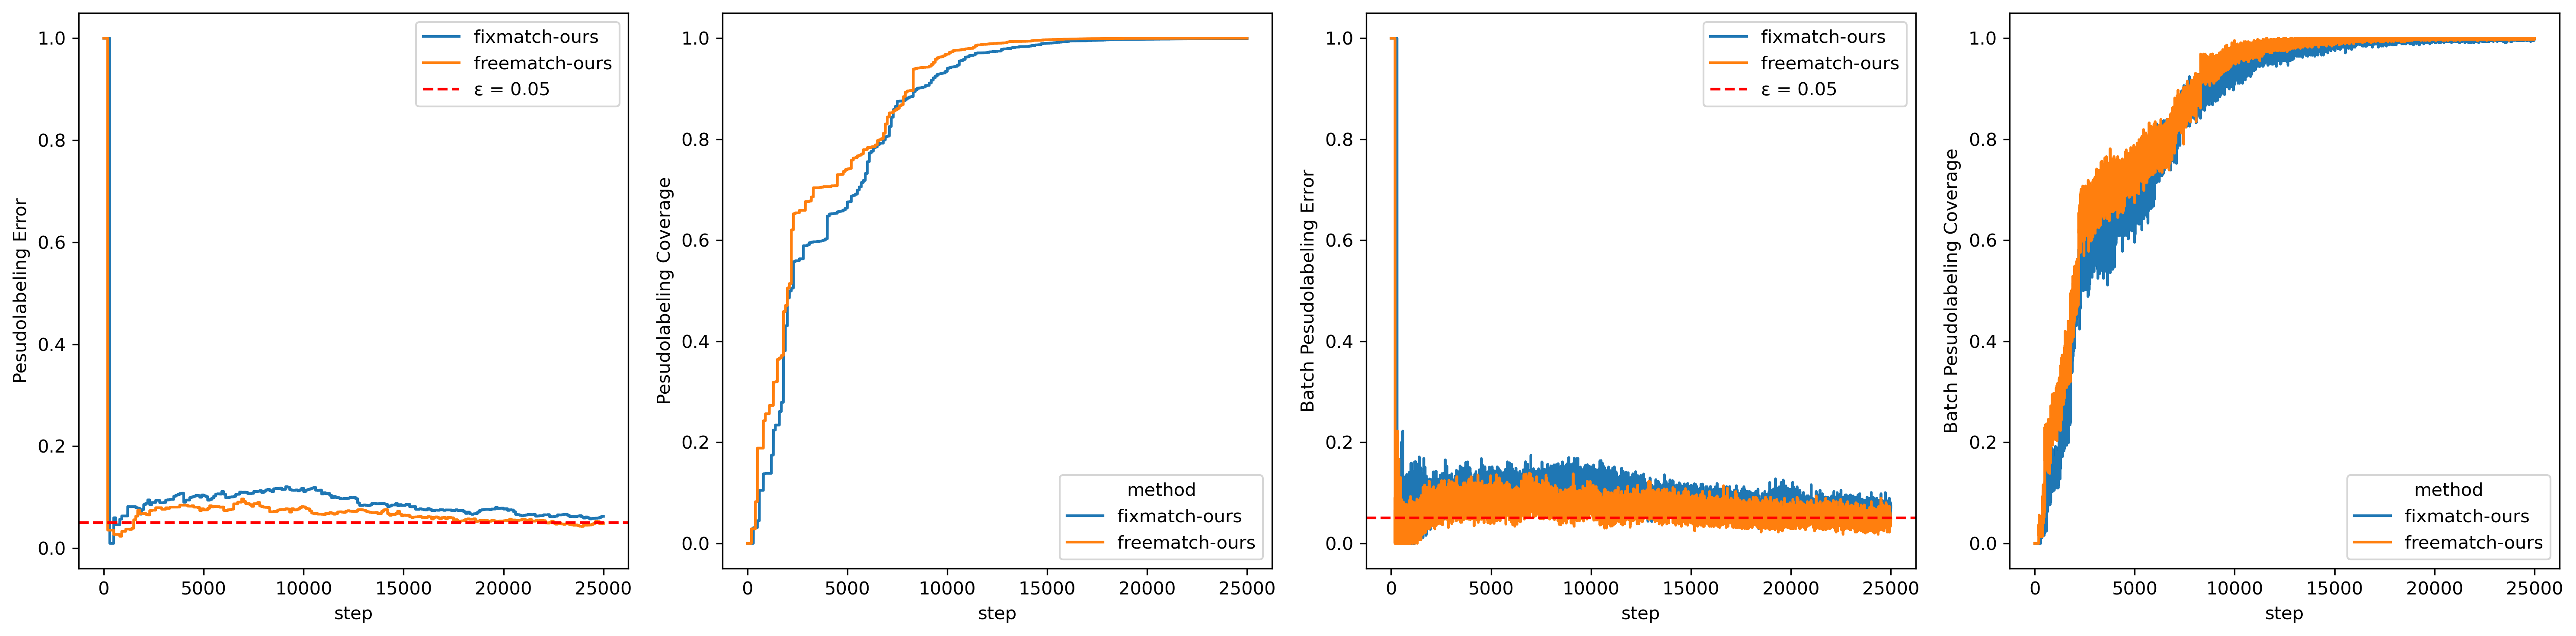

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

sns.lineplot(data=results_df[results_df.seed == "0"], x="step", y="pl_err", hue="method", ax=axes[0])
axes[0].set_ylabel("Pesudolabeling Error")
axes[0].axhline(y=0.05, color='r', linestyle='--', label='ε = 0.05')
axes[0].legend()

sns.lineplot(data=coverage_results_df[coverage_results_df.seed == "0"], x="step", y="value", hue="method", ax=axes[1])
axes[1].set_ylabel("Pesudolabeling Coverage")

sns.lineplot(data=batch_results_df[batch_results_df.seed == "0"], x="step", y="batch_pl_err", hue="method", ax=axes[2])
axes[2].set_ylabel("Batch Pesudolabeling Error")
axes[2].axhline(y=0.05, color='r', linestyle='--', label='ε = 0.05')
axes[2].legend()

sns.lineplot(data=batch_coverage_results_df[batch_coverage_results_df.seed == "0"], x="step", y="value", hue="method", ax=axes[3])
axes[3].set_ylabel("Batch Pesudolabeling Coverage")

plt.tight_layout()
plt.show()